In [33]:
BENCHMARK_TOOL = 'NVPROF' # or 'NVPROF'

import subprocess
import numpy as np
import pandas as pd
import io
from matplotlib import pyplot as plt 
from typing import Tuple

In [34]:
def read_nvprof(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[3].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

    
def read_ncu(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[2].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

def benchmark_kernel(exe_path: str, *args) -> str :
    if BENCHMARK_TOOL == 'NVPROF':
        return str(subprocess.check_output(
            ['nvprof', '--print-gpu-trace', '--csv', exe_path, *args], 
            stderr=subprocess.STDOUT
        ))
    elif BENCHMARK_TOOL == 'NCU':
        return str(subprocess.check_output(
            ['ncu','--csv', exe_path, *args], 
            stderr=subprocess.STDOUT, shell=True
        ))

def read_benchmark(output: str) -> pd.DataFrame:
    if BENCHMARK_TOOL == 'NVPROF':
        return read_nvprof(output)
    elif BENCHMARK_TOOL == 'NCU':
        return read_ncu(output)

def get_kernel_duration(df: pd.DataFrame) -> float:
    if BENCHMARK_TOOL == 'NVPROF':
        return float(df.loc[2, 'Duration']) * 1e-3
    elif BENCHMARK_TOOL == 'NCU':
        return float(df[df['Metric Name'] == 'Duration']['Metric Value'].to_numpy().item().replace(',','')) * 1e-6

In [35]:
kernelDurations = []
for i in range(0, 4):
    kernelDurations.append(
        get_kernel_duration(
            read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(i)))
        ) # * 1e3
    )

print(kernelDurations) # En milliseconde

[0.028432334, 0.006665018, 0.007718903, 0.0061148619999999996]


In [36]:
print("benchmark RGB To HSV:")
read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(0))) 

benchmark RGB To HSV:


,"""Start",Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Device,Context,Stream,Name,"Correlation_ID"""
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,292.576235,0.157119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759644,10.936945,Pageable,Device,NVIDIA Quadro P620 (0),1.0,7.0,[CUDA memcpy HtoD],118.0
2,292.745801,26.813251,32.0,1.0,1.0,1.0,1.0,1.0,19.0,0,0,NaN,NaN,NaN,NaN,NVIDIA Quadro P620 (0),1.0,7.0,"rgb2hsv(unsigned char const *, unsigned int, f...",119.0
3,',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
print("benchmark égaliser l'histogramme:")
read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", str(3))) 

benchmark égaliser l'histogramme:


,"""Start",Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Device,Context,Stream,Name,"Correlation_ID"""
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,283.769411,0.186909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759644,9.193789,Pageable,Device,NVIDIA Quadro P620 (0),1.0,7.0,[CUDA memcpy HtoD],118.0
2,283.970400,6.848772,32.0,32.0,1.0,1.0,1.0,1.0,19.0,0,0,NaN,NaN,NaN,NaN,NVIDIA Quadro P620 (0),1.0,7.0,"rgb2hsv(unsigned char const *, unsigned int, f...",119.0
3,290.819748,8.738378,32.0,1.0,1.0,1.0,1.0,1.0,10.0,0,0,NaN,NaN,NaN,NaN,NVIDIA Quadro P620 (0),1.0,7.0,"histogram(float const *, unsigned int, unsigne...",120.0
4,299.558958,0.037344,32.0,1.0,1.0,1.0,1.0,1.0,28.0,0,0,NaN,NaN,NaN,NaN,NVIDIA Quadro P620 (0),1.0,7.0,"repart(unsigned int const *, unsigned int, uns...",121.0
5,299.596878,11.470598,32.0,1.0,1.0,1.0,1.0,1.0,12.0,0,0,NaN,NaN,NaN,NaN,NVIDIA Quadro P620 (0),1.0,7.0,"equalization(unsigned int const *, unsigned in...",122.0
6,',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
xBlockSize = 1
yBlockSize = 1
durations = []
sizes = []

average = 0
nTry = 10
while xBlockSize <= 1024:
    for i in range(nTry) :         
        average += get_kernel_duration(read_benchmark(benchmark_kernel("./hist", "-f", "./img/chateau.png", "-b", "1", "-d", str(xBlockSize), str(yBlockSize))))

    average /= nTry
    durations.append(average)    
    sizes.append(xBlockSize)
    xBlockSize *= 2

print(durations) 
print(sizes) 

[0.0065380717, 0.007005817069999999, 0.0070652716069999994, 0.0073543643607, 0.007041621436070002, 0.007400876543607, 0.007774067654360702, 0.00771776086543607, 0.006805218186543607, 0.00722418911865436, 0.006600426911865435]
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


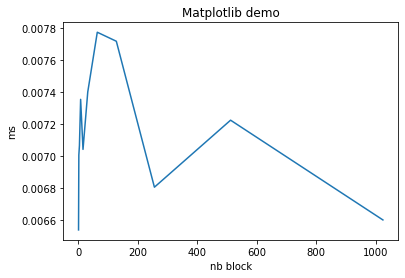

In [43]:

plt.title("Matplotlib demo")  
plt.xlabel("nb block") 
plt.ylabel("ms") 
plt.plot(sizes, durations) 
plt.show()  